In [1]:
!pip install backtrader
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 26.8 MB/s eta 0:00:00


In [2]:
import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
import backtrader.indicators
import datetime
import yfinance as yf
import matplotlib as plt

In [3]:
class EMA_RSI(bt.Strategy):

    params = (('EMA_F', 9), ('EMA_S', 26), ('RSI', 14)) # Lookback Period for EMA and RSI

    ''' Create 3 parameters EMA_F, EMA_S, RSI and set their values to 9, 26, 14 '''



    def __init__(self):
        self.order = None
        self.stopprice = None
        self.closepos = None
        self.emaf = bt.indicators.EMA(self.data.close, period=self.params.EMA_F)  # Initialise the faster EMA
        self.emas = bt.indicators.EMA(self.data.close, period=self.params.EMA_S)  # Initialise the slower EMA
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=self.params.RSI) # Initialise RSI


    def log(self, txt, doprint=True):
        date = self.data.datetime.date(0)
        time = self.data.datetime.time(0)
        if doprint:
            print(str(date) + '--' + txt)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        elif order.status == order.Completed:
            if order.isbuy():
                self.log('BUY   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
            if order.issell():
                self.log('SELL   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
        elif order.status in [order.Rejected, order.Margin]:
            self.log('Order Rejected/Margin')

        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('CLOSE   Gross P/L: {}, Net P/L: {}'.format(trade.pnl, trade.pnlcomm))


    def next(self):
        if self.order:
            return

        if self.position.size == 0:

                '''

                Place order for SELL if fast ema is less than slow ema and rsi is greater than 70
                Place order for BUY if fast ema is greater than slow ema and rsi is less than 30

                '''
                if (self.emaf > self.emas) and self.rsi < 30:
                    self.order = self.buy()

                if (self.emaf < self.emas) and self.rsi > 30:
                    self.order = self.sell()


        elif self.position.size > 0:

            '''

            Close LONG position if close is greater than or equal to fast ema and rsi being greater than 70

            '''
            if (self.emaf < self.emas) and self.rsi > 70:
              self.closepos = self.close()

        elif self.position.size < 0:

            '''

            Close SHORT position if close is less than or equal to fast ema and rsi being less than 30

            '''
            if (self.emaf > self.emas) and self.rsi < 70:
              self.closepos = self.close()


In [4]:
cerebro = bt.Cerebro() # Initialise the bot

datapath = 'INFY.NS.csv' # To set a sub-folder from where data feed will be collected
feed = bt.feeds.PandasData(dataname=yf.download('INFY.NS', '2020-01-01', '2023-04-30')) # To set the data feed
cerebro.adddata(feed) # To feed the data into Cerebro engine

cerebro.addstrategy(EMA_RSI) # To add the strategy
cerebro.broker.setcash(100000.0) # To set initial portfolio value
cerebro.broker.setcommission(commission=.0002) # To set broker commission

cerebro.addsizer(bt.sizers.PercentSizer, percents=90) # To allocate percentage of portfolio to execute an order

[*********************100%***********************]  1 of 1 completed


In [5]:
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(btanalyzers.DrawDown, _name='maxdrawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

In [6]:
def printDrawDownAnalysis(analyzer): # Function to print the Technical Analysis results in a nice format.

    # Get the results we are interested in
    drawdown = round(analyzer.drawdown, 2)
    moneydown = round(analyzer.moneydown, 2)
    length = analyzer.len
    max_dd = round(analyzer.max.drawdown, 2)
    max_md = round(analyzer.max.moneydown, 2)
    max_len = analyzer.max.len
    h1 = ['Drawdown', 'Moneydown', 'Length']
    h2 = ['Max drawdown','Max moneydown', 'Max len']
    r1 = [drawdown, moneydown,length]
    r2 = [max_dd, max_md, max_len]
    # Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    # Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Drawdown Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))


def printTradeAnalysis(analyzer): # Function to print the Technical Analysis results in a nice format.

    # Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = round((total_won / total_closed) * 100)
    # Designate the rows
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed, total_won, total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    # Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    # Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))

In [7]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue()) # Print the initial portfolio value
backtest_result = cerebro.run()
backtest_result_1 = backtest_result[0]
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) # Print the final portfolio value
print('Sharpe Ratio:', backtest_result_1.analyzers.mysharpe.get_analysis())
printDrawDownAnalysis(backtest_result_1.analyzers.maxdrawdown.get_analysis()) # To get detailed Drawdown and Trade analysis
printTradeAnalysis(backtest_result_1.analyzers.ta.get_analysis())

Starting Portfolio Value: 100000.00
2020-03-03--SELL   price: 755.0, value: -91694.21917456879, commission: 18.33884383491376
2020-04-27--BUY   price: 661.0499877929688, value: -91694.21917456879, commission: 16.056811249280663
2020-04-27--CLOSE   Gross P/L: 11410.16292816548, Net P/L: 11375.767273081286
2020-09-02--BUY   price: 915.0, value: 100331.3918939841, commission: 20.06627837879682
2022-07-07--SELL   price: 1503.0500488281252, value: 100331.3918939841, commission: 32.96242699131072
2022-07-07--CLOSE   Gross P/L: 64480.7430625695, Net P/L: 64427.71435719939
2022-07-13--SELL   price: 1450.0, value: -159476.9549708026, commission: 31.89539099416052
2022-07-21--BUY   price: 1517.0, value: -159476.9549708026, commission: 33.36917802630449
2022-07-21--CLOSE   Gross P/L: -7368.935160719844, Net P/L: -7434.1997297403095
2022-09-12--SELL   price: 1525.800048828125, value: -152950.79479796943, commission: 30.590158959593886
2022-10-20--BUY   price: 1475.0, value: -152950.79479796943, co

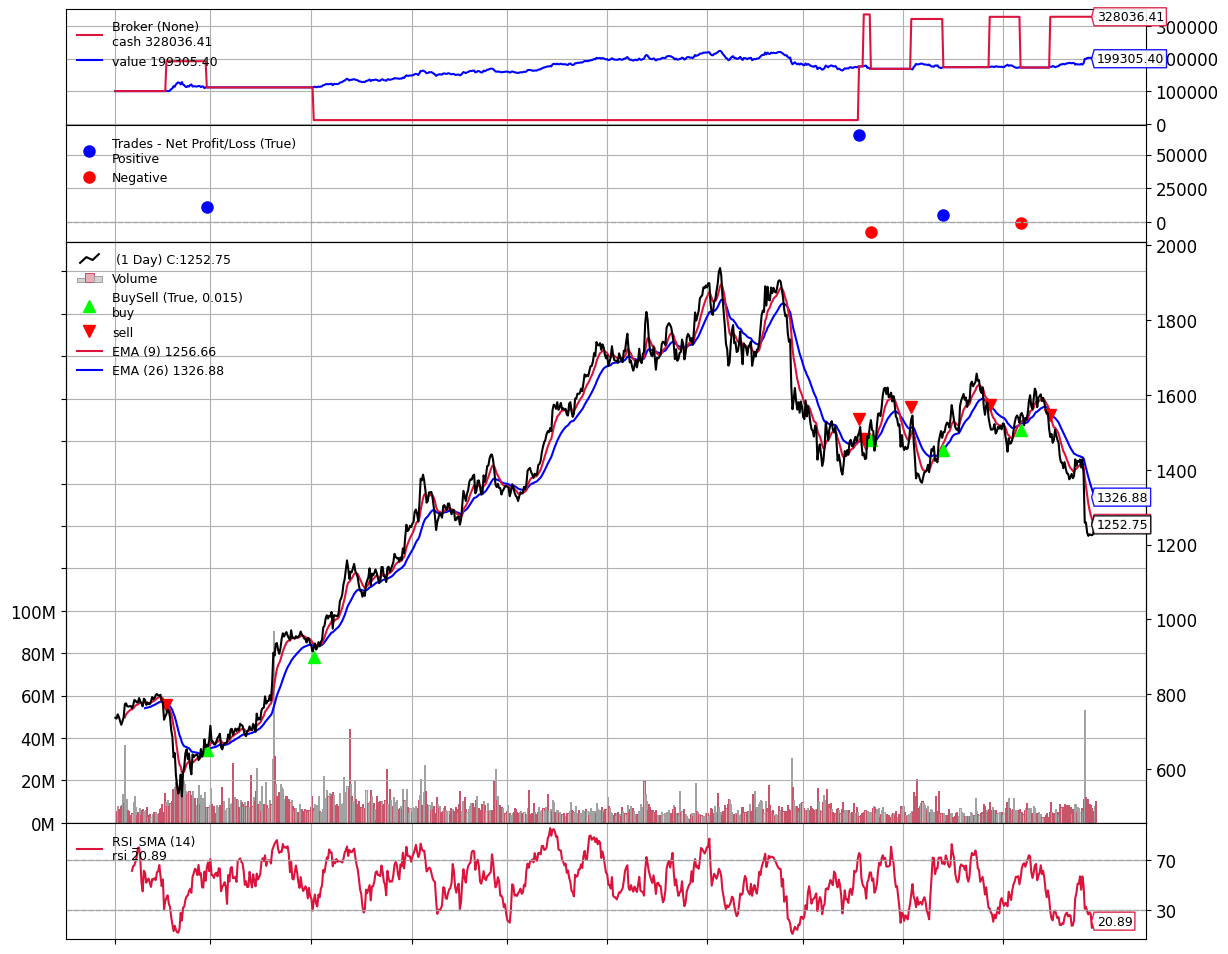

[[<Figure size 1200x1000 with 5 Axes>]]

In [8]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams.update({'font.size': 12})
cerebro.plot(iplot = False)